In [37]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
df = pd.read_csv(r"D:\samyak\coding\data analysis projects\F1_data\2024_races.csv", parse_dates=["time"])
df = df.set_index("time").to_period('S')
def to_seconds(x):
    
    # Convert to timedelta
    df[x] = pd.to_timedelta(df[x])

    # Convert to total seconds
    df[x] = df[x].dt.total_seconds()
time_clean =  ['LapTime','Sector2Time','Sector3Time']
for i in time_clean:
    to_seconds(i)

df = df['LapTime']
df=pd.DataFrame(df)
df

,LapTime
time,
2024-03-09 17:59:59,97.284
2024-03-09 18:01:37,96.296
2024-03-09 18:03:13,96.753
2024-03-09 18:04:50,96.647
2024-03-09 18:06:27,97.173
...,...
2024-03-09 19:13:16,92.557
2024-03-09 19:14:48,92.574
2024-03-09 19:16:21,92.657


In [38]:
df.shape

(1980, 1)

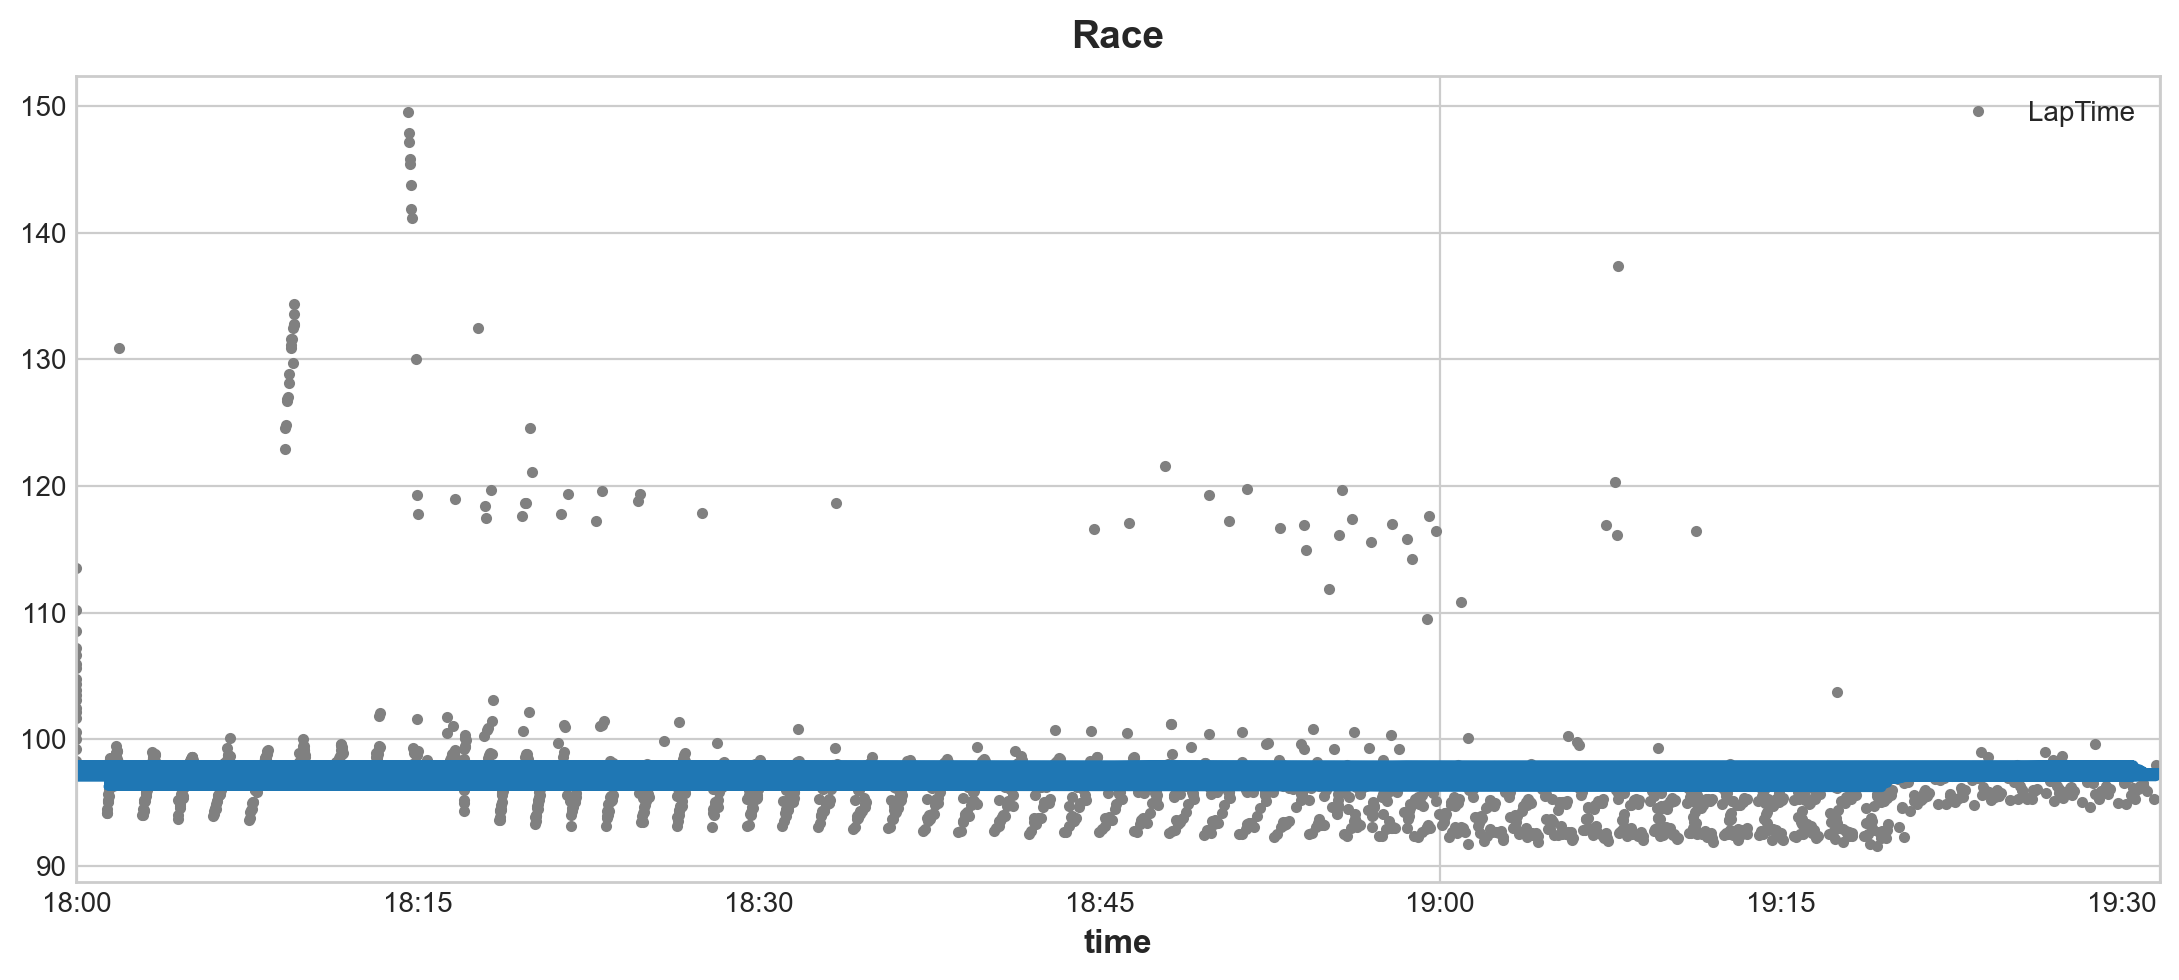

In [39]:
moving_average = df.rolling(
    window=1980,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=990,  # choose about half the window size
).mean()                 # compute the mean (could also do median, std, min, max, ...)

ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Race", legend=False,
);

In [40]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
time,,
2024-03-09 17:59:59,1.0,1.0
2024-03-09 18:01:37,1.0,2.0
2024-03-09 18:03:13,1.0,3.0
2024-03-09 18:04:50,1.0,4.0
2024-03-09 18:06:27,1.0,5.0


In [41]:
print(df.columns)

Index(['LapTime'], dtype='object')


In [42]:
from sklearn.linear_model import LinearRegression

y = df["LapTime"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

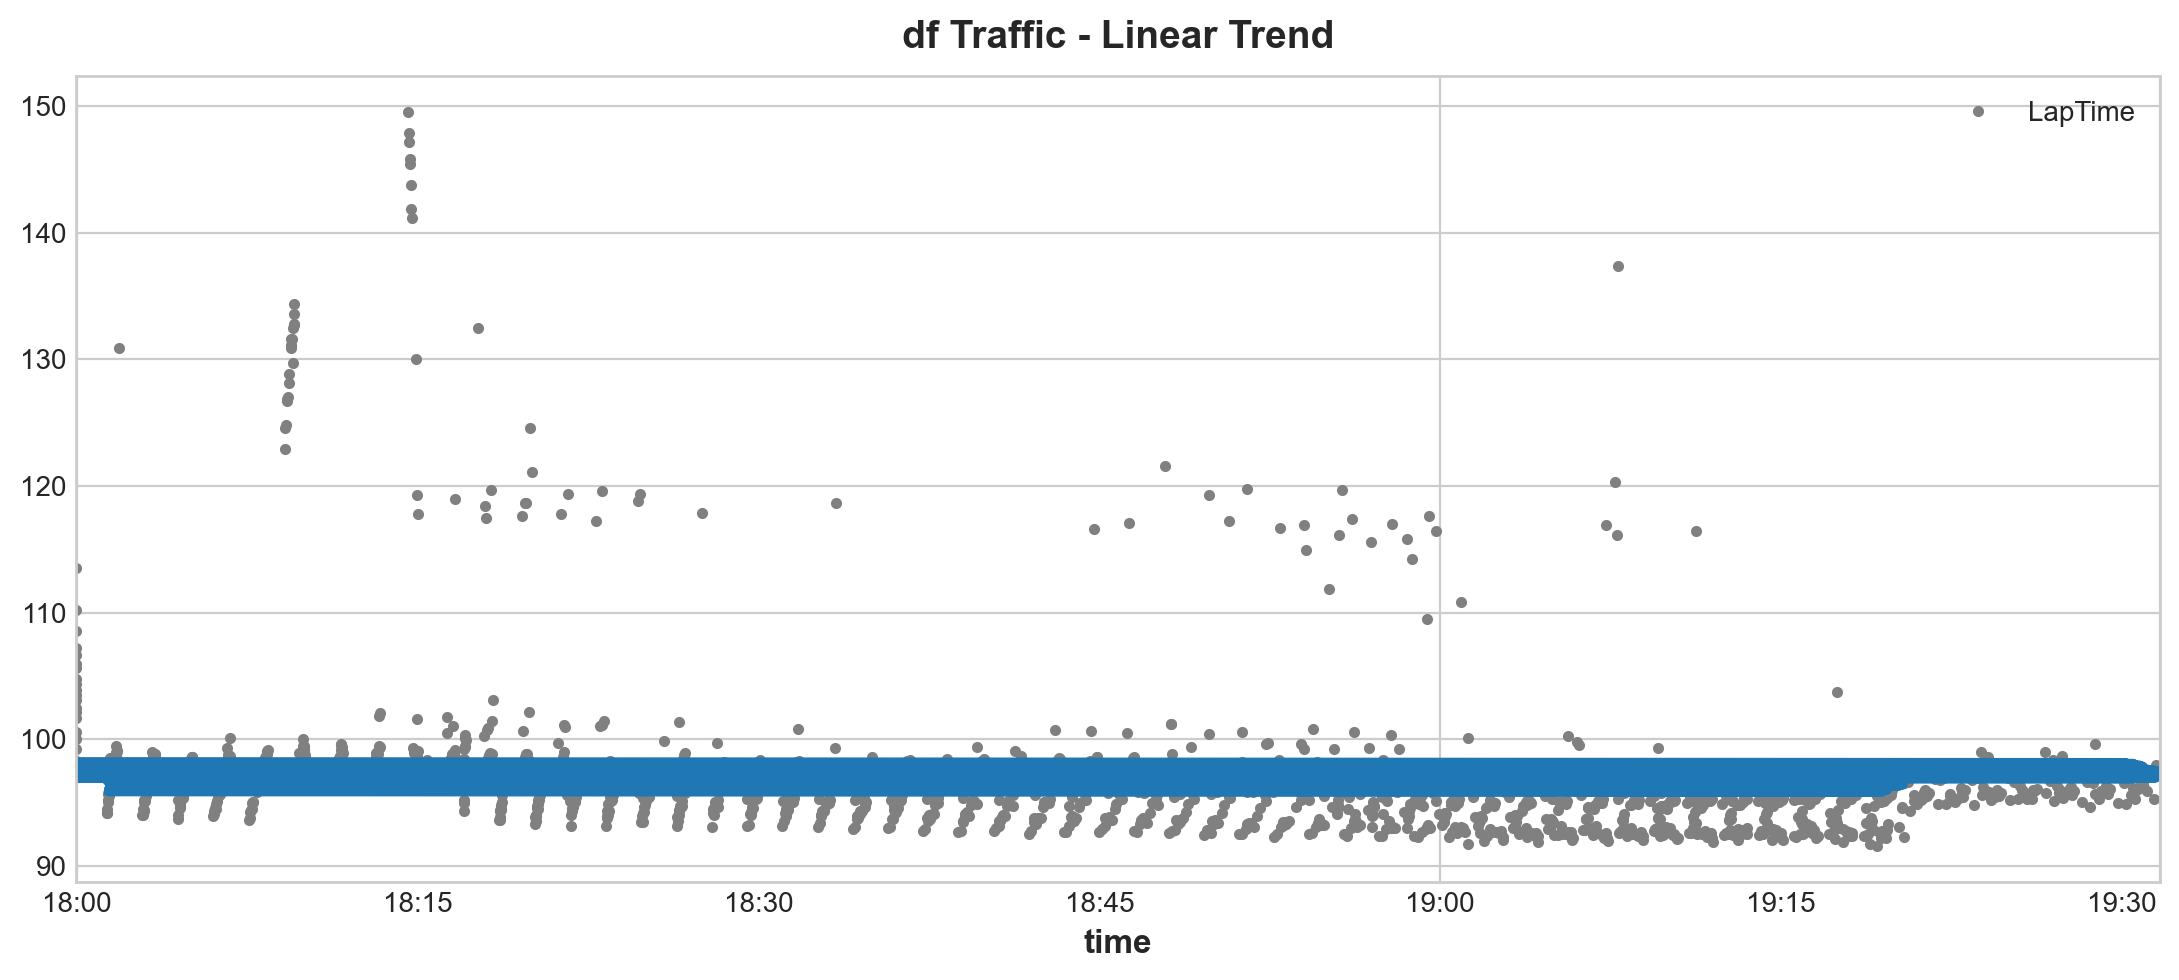

In [43]:
ax = df.plot(style=".", color="0.5", title="df Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [44]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2024-03-09 19:19:27    95.795449
2024-03-09 19:19:28    95.794194
2024-03-09 19:19:29    95.792940
2024-03-09 19:19:30    95.791685
2024-03-09 19:19:31    95.790430
Freq: S, dtype: float64